In [144]:
#Imports
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt

pre-process (cropping out faces using haarcascade)

In [145]:
import cv2
from PIL import Image
import numpy as np
import os

def preprocess_face(img_path):
  # Load image using OpenCV (assuming color images)
  img = cv2.imread(img_path)

  # Convert to grayscale (if needed for face detection)
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  # Load a Haar cascade classifier for face detection (replace with your downloaded file)
  face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')  # Replace path

  # Detect faces
  faces = face_cascade.detectMultiScale(gray, 1.1, 4)

  # Process first detected face (assuming single face per image)
  if len(faces) > 0:
    (x, y, w, h) = faces[0]
    # Extract the face region
    face_img = img[y:y+h, x:x+w]

    # Convert face to PIL image format for further processing (optional)
    face_img = Image.fromarray(face_img)

    # Apply additional preprocessing steps (e.g., resize, normalize)
    preprocessed_face = np.array(face_img.convert('L').resize((100, 100)))

    return preprocessed_face
  else:
    # print(f"Warning: No face detected in image {img_path}")
    return None  # Handle cases where no face is detected

def load_data(data_path):
  images = list()
  labels = list()

  for folder in os.listdir(data_path):
    for img in os.listdir(data_path + "/" + folder):
      # Construct complete image path
      img_path = os.path.join(data_path, folder, img)

      # Preprocess the image
      preprocessed_img = preprocess_face(img_path)

      if preprocessed_img is not None: 
        label = folder
        images.append(preprocessed_img)
        labels.append(label)

  print(f"{data_path} data loaded!")
  return images, labels

# Define paths to your data directories
GALLERY = "data/train"
PROBE = "data/val"

# Load training data
train_images, train_labels = load_data(GALLERY)

# Load validation data
val_images, val_labels = load_data(PROBE)


data/train data loaded!
data/val data loaded!


In [146]:
print(len(train_images))
# len(val_images)
shape = train_images[0].shape
shape[1]


85


100

In [147]:
shape = train_images[0].shape
X = np.resize(train_images, (len(train_images), shape[0]*shape[1]))
mean = np.mean(X, axis = 0)
X_std = X - mean
# train_images = np.resize(train_images, (len(train_images), shape[0]*shape[1]))

In [148]:
X_std.shape

(85, 10000)

covariance matrix

In [149]:
# cov = np.cov(X_std)
cov = X_std @ X_std.T
cov.shape

(85, 85)

In [150]:
eigenvalues, eigenvectors = np.linalg.eig(cov)
idx = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:,idx]

In [151]:
eigenvector_converted = X_std.T @ eigenvectors
# eigenvector_converted = np.dot(X_std.T, eigenvectors)
eigenvector_converted.shape

(10000, 85)

In [152]:
eigenfaces = eigenvector_converted.T/ np.sqrt((eigenvector_converted.T ** 2).sum(axis=1, keepdims=True))
eigenfaces.shape

(85, 10000)

eigenfaces


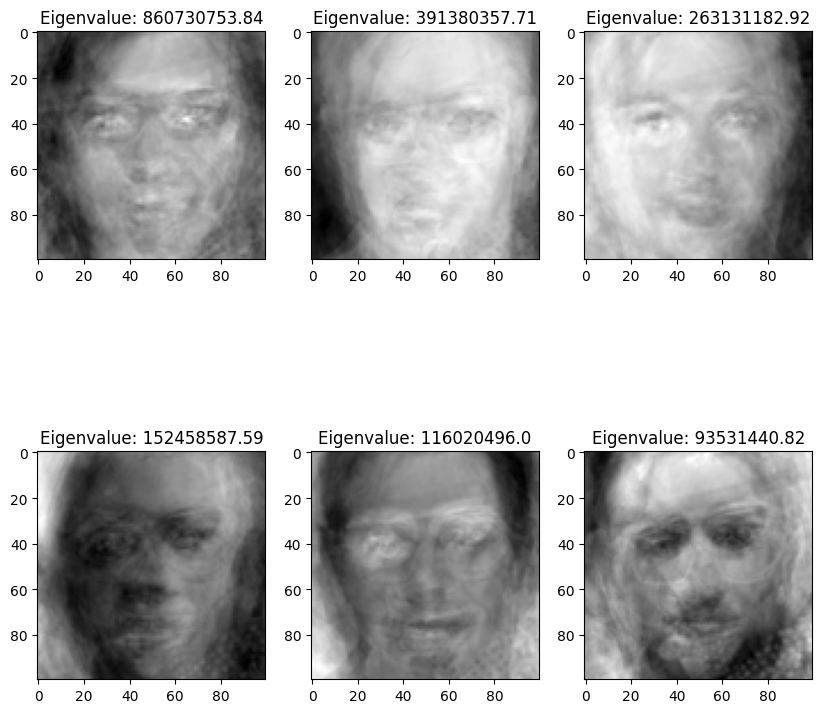

In [153]:
_, axs = plt.subplots(2, 3, figsize=(10, 10))
axs = axs.flatten()
for i, (img, ax) in enumerate(zip(eigenfaces, axs)):
    ax.set_title(f"Eigenvalue: {np.round(eigenvalues[i], 2)}")
    ax.imshow(img.reshape(shape[0], shape[1]), cmap="gray")
plt.show()

In [154]:
eigenvalues[-1]

2.291436311918269e-08

In [155]:
total = sum(eigenvalues)

explained_variance = [(i / total) * 100 for i in eigenvalues]
explained_variance = np.round(explained_variance, 2)

cum_explained_variance = np.cumsum(explained_variance)

In [156]:
x = list()

y = [85, 95]

for dim in range(85):
    if cum_explained_variance[dim] >= y[0]:
        x.append(dim+1)
        break

for dim in range(x[0]+1, 85):
    if cum_explained_variance[dim] >= y[1]:
        x.append(dim+1)
        break

In [157]:
x

[24, 49]

percentage variance graph

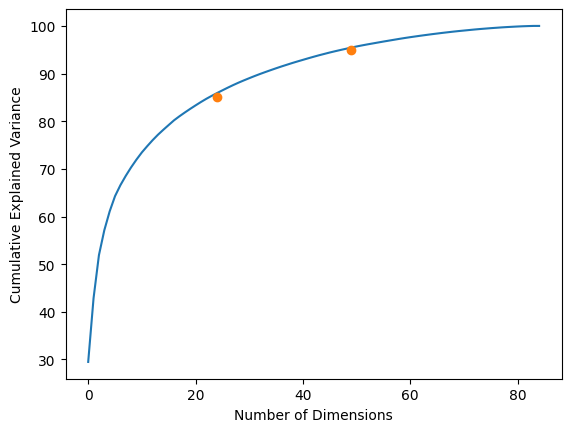

In [158]:
# A graph depicting the percentage of the total variance of the original data retained in the reduced space versus the number of dimensions.
plt.plot(cum_explained_variance)
plt.plot(x, y, "o")
plt.xlabel("Number of Dimensions")
plt.ylabel("Cumulative Explained Variance")
plt.show()

recontructing train set image using the eigen-faces

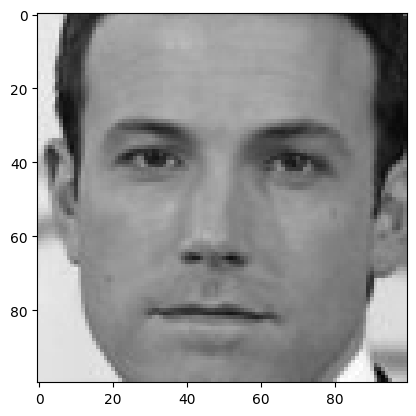

In [159]:
train_img = np.array(train_images[0])
train_image_mean_centered = train_img.reshape(shape[0]*shape[1]) - mean
plt.imshow(train_img.reshape(shape[0], shape[1]), cmap = 'gray')
plt.show()

Reconstruction errors: (MSE)
1 eigenfaces: 17526106.310229126
4 eigenfaces: 11445347.925115278
16 eigenfaces: 6855514.6817137785
25 eigenfaces: 5037935.340564325
36 eigenfaces: 3669084.3719472066
49 eigenfaces: 2198633.938609234
64 eigenfaces: 1480742.4166391056
81 eigenfaces: 1646.6033505761652
84 eigenfaces: 1.501875164384593e-20
85 eigenfaces: 1607.3275498444088


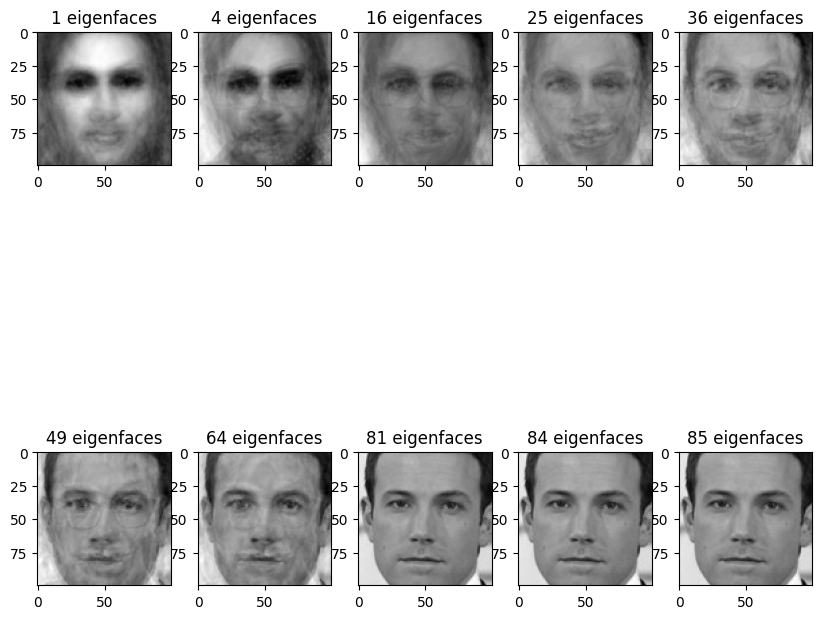

In [160]:
count = [1, 4, 16, 25, 36, 49, 64, 81, 84, 85]
_, axs = plt.subplots(2, 5, figsize=(10, 10))
axs = axs.flatten()
# Define a list of indices 'count' indicating the number of eigenfaces to use for reconstruction
print("Reconstruction errors: (MSE)")
for i, (img, ax) in enumerate(zip(eigenfaces, axs)):
    # Calculate the reconstruction using the selected number of eigenfaces
    E = eigenfaces[:count[i]].dot(train_image_mean_centered)
    reconstruction = eigenfaces[:count[i]].T.dot(E) + mean
    
    # Calculate the difference between the original and reconstructed images
    diff = train_image_mean_centered + mean - reconstruction
    
    # Calculate the Mean Squared Error (MSE) as the reconstruction error
    error = np.dot(diff, diff)
    print(str(count[i]) + " eigenfaces: " + str(error))
    
    # Display the reconstructed image in grayscale
    ax.set_title(str(count[i]) + " eigenfaces")
    ax.imshow(np.reshape(reconstruction, (shape[0], shape[1])), cmap='gray')
plt.show()

recontructing validation set images using the eigen-faces

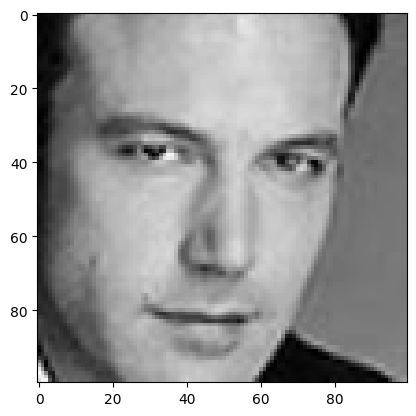

In [166]:
val_img = np.array(val_images[2])
val_image_mean_centered = val_img.reshape(shape[0]*shape[1]) - mean
plt.imshow(val_img.reshape(shape[0], shape[1]), cmap = 'gray')
plt.show()

Reconstruction errors: (MSE)
1 eigenfaces: 15571984.242697049
4 eigenfaces: 10911407.62832496
16 eigenfaces: 8348794.890698813
25 eigenfaces: 6431208.778765558
36 eigenfaces: 4184390.8920055716
49 eigenfaces: 3506635.5971216657
64 eigenfaces: 2596491.4993547266
81 eigenfaces: 2217430.8841882558
84 eigenfaces: 2211189.979305974
85 eigenfaces: 2216992.2154598297


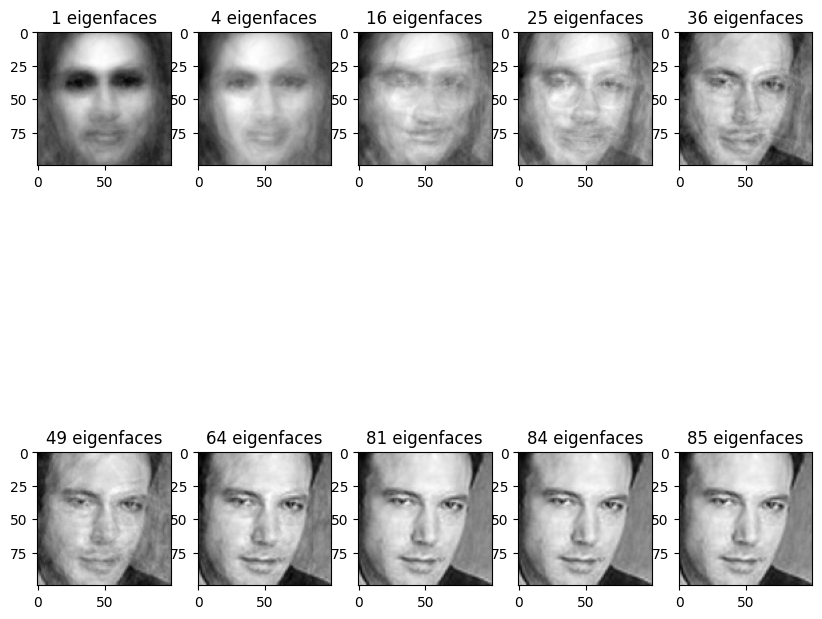

In [167]:
_, axs = plt.subplots(2, 5, figsize=(10, 10))
axs = axs.flatten()
# Define a list of indices 'count' indicating the number of eigenfaces to use for reconstruction
count = [1, 4, 16, 25, 36, 49, 64, 81, 84, 85]
print("Reconstruction errors: (MSE)")
for i, (img, ax) in enumerate(zip(eigenfaces, axs)):
    # Calculate the reconstruction using the selected number of eigenfaces
    E = eigenfaces[:count[i]].dot(val_image_mean_centered)
    reconstruction = eigenfaces[:count[i]].T.dot(E) + mean
    
    # Calculate the difference between the original and reconstructed images
    diff = val_image_mean_centered + mean - reconstruction
    
    # Calculate the Mean Squared Error (MSE) as the reconstruction error
    error = np.dot(diff, diff)
    print(str(count[i]) + " eigenfaces: " + str(error))
    
    # Display the reconstructed image in grayscale
    ax.set_title(str(count[i])+" eigenfaces")
    ax.imshow(np.reshape(reconstruction,(shape[0],shape[1])),cmap='gray')
plt.show()

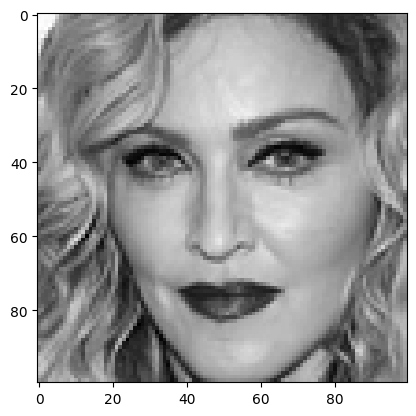

In [163]:
val_img = np.array(val_images[17])
val_image_mean_centered = val_img.reshape(shape[0]*shape[1]) - mean
plt.imshow(val_img.reshape(shape[0], shape[1]), cmap = 'gray')
plt.show()

Reconstruction errors: (MSE)
1 eigenfaces: 9948570.12505603
4 eigenfaces: 9104840.689535338
16 eigenfaces: 7357763.8477957705
25 eigenfaces: 6917968.482861018
36 eigenfaces: 6501942.449122027
49 eigenfaces: 6054536.583967274
64 eigenfaces: 5812272.22491334
81 eigenfaces: 5397794.485014975
84 eigenfaces: 5365011.10851464
85 eigenfaces: 5462461.497358072


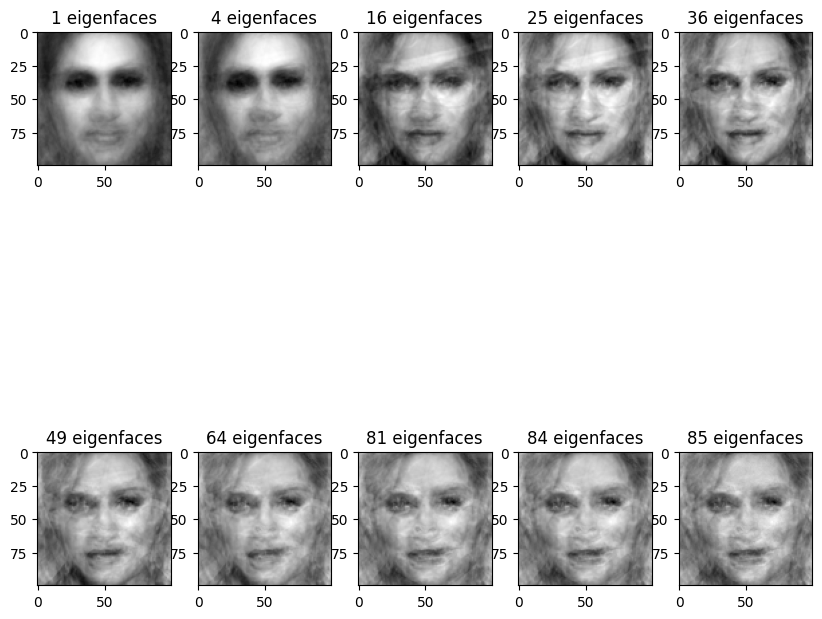

In [164]:
_, axs = plt.subplots(2, 5, figsize=(10, 10))
axs = axs.flatten()
# Define a list of indices 'count' indicating the number of eigenfaces to use for reconstruction
count = [1, 4, 16, 25, 36, 49, 64, 81, 84, 85]
print("Reconstruction errors: (MSE)")
for i, (img, ax) in enumerate(zip(eigenfaces, axs)):
    # Calculate the reconstruction using the selected number of eigenfaces
    E = eigenfaces[:count[i]].dot(val_image_mean_centered)
    reconstruction = eigenfaces[:count[i]].T.dot(E) + mean
    
    # Calculate the difference between the original and reconstructed images
    diff = val_image_mean_centered + mean - reconstruction
    
    # Calculate the Mean Squared Error (MSE) as the reconstruction error
    error = np.dot(diff, diff)
    print(str(count[i]) + " eigenfaces: " + str(error))
    
    # Display the reconstructed image in grayscale
    ax.set_title(str(count[i])+" eigenfaces")
    ax.imshow(np.reshape(reconstruction,(shape[0],shape[1])),cmap='gray')
plt.show()

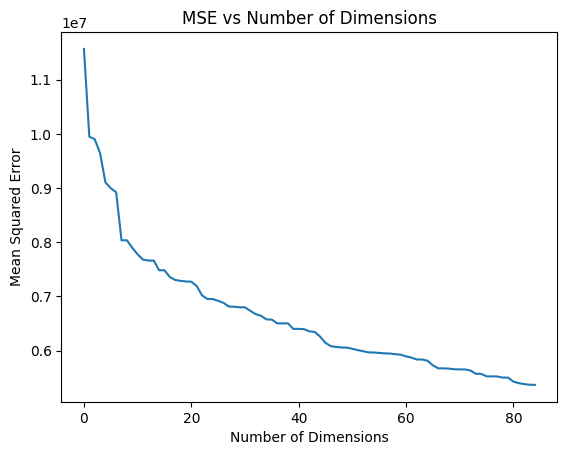

In [165]:
errors = list()
for i in range(85):
    # Project the test image onto the first 'i' principal components
    E = eigenfaces[:i].dot(val_image_mean_centered)
    
    # Reconstruct the test image using the selected number of dimensions
    reconstruction = eigenfaces[:i].T.dot(E) + mean
    
    # Calculate the difference between the original test image and the reconstructed image
    diff = val_image_mean_centered + mean - reconstruction
    
    # Calculate the Mean Squared Error (MSE) as the reconstruction error
    error = np.dot(diff, diff)
    errors.append(error)

# Plot the MSE values against the number of dimensions used for reconstruction
plt.plot(errors)
plt.title("MSE vs Number of Dimensions")
plt.xlabel("Number of Dimensions")
plt.ylabel("Mean Squared Error")
plt.show()